# Predizione Qualità Mele: Progetto ML

Falbo Andrea 887525 \\
Pellegrini Damiano 886261 \\
Tenderini Ruben 879290 \\

### Importazione delle librerie

In questo blocco di codice vengono importate diverse librerie necessarie per il progetto di machine learning:

- **Librerie per la gestione dei dati e la visualizzazione**: `pandas` per la manipolazione dei dati, `numpy` per operazioni numeriche, e `matplotlib` e `seaborn` per la visualizzazione dei risultati.
- **Librerie di machine learning**: vengono importati vari modelli e strumenti da `scikit-learn` per la creazione, la valutazione e l'ottimizzazione dei modelli, come classificatori, scaler, e metodi di validazione incrociata.
- **Librerie di supporto**: `warnings` per la gestione degli avvisi e `os` per interazioni con il sistema operativo. Viene anche importato `kagglehub` per facilitare l'accesso ai dataset di Kaggle.

In [2]:
from numpy import float16, float32, float64
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import (
    VotingClassifier,
)
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
import os

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.svm import SVC

import kagglehub

import random

### Caricamento del dataset

In questo blocco di codice:

1. Viene scaricato il dataset "apple-quality" utilizzando la funzione `dataset_download` di `kagglehub`.
2. Successivamente, viene costruito il percorso completo del file CSV del dataset utilizzando `os.path.join`.
3. Infine, il file CSV viene caricato in un DataFrame Pandas tramite la funzione `pd.read_csv` per l'analisi e la manipolazione dei dati.

In [4]:
path_to_dataset = kagglehub.dataset_download("nelgiriyewithana/apple-quality")
dataset = os.path.join(path_to_dataset, "apple_quality.csv")
df = pd.read_csv(dataset)

100%|██████████| 170k/170k [00:00<00:00, 63.0MB/s]

Extracting files...


### Visualizzazione delle prime righe del dataset

Il comando `df.head()` viene utilizzato per visualizzare le prime 5 righe del DataFrame `df`. Questo permette di avere un'idea generale della struttura del dataset, delle sue colonne e dei primi valori presenti.

In [5]:
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


### Informazioni sul dataset

Il comando `df.info()` viene utilizzato per ottenere informazioni generali sul DataFrame `df`. Questo include il numero di righe, il numero di colonne, i tipi di dato di ciascuna colonna e la presenza di eventuali valori mancanti.

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


### Numero di valori unici per colonna

Il comando `df.nunique(dropna=False)` restituisce il numero di valori unici per ciascuna colonna del DataFrame `df`, includendo anche i valori mancanti (NaN).

In [7]:
df.nunique(dropna=False)

,0
A_id,4001
Size,4001
Weight,4001
Sweetness,4001
Crunchiness,4001
Juiciness,4001
Ripeness,4001
Acidity,4001
Quality,3


### Identificazione delle righe con valori mancanti

Il comando `df[df.isnull().any(axis = 1)]` viene utilizzato per selezionare le righe del DataFrame `df` che contengono almeno un valore mancante (NaN). In questo caso, è stato usato per identificare la riga contenente i crediti

In [8]:
df[df.isnull().any(axis = 1)]

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Created_by_Nidula_Elgiriyewithana,NaN


In [9]:
df = df.dropna() # Per rimuovere la riga dei crediti
df = df.drop(columns=['A_id'])

### Verifica dei duplicati nel dataset

Il comando `df.duplicated().sum()` verifica la presenza di righe duplicate nel DataFrame `df`. Restituisce il numero di righe duplicate. Usato per verificare l'assenza di dati duplicati.


In [10]:
print("Duplicated:", df.duplicated().sum())

Duplicated: 0


### Casting dati e conversione
- **Casting a tipi meno spaziosi**: Vengono convertiti alcuni attributi numerici (come "Size", "Weight", "Sweetness", ecc.) a tipi di dato `float32` per ridurre l'uso di memoria, mantenendo comunque una buona precisione per l'analisi.
- **Conversione della variabile target**: La variabile "Quality", che è categorica, viene trasformata in valori numerici, dove "bad" diventa 0 e "good" diventa 1, e successivamente viene salvata come tipo `int8` per ottimizzare l'uso della memoria durante le analisi di correlazione.

In [11]:
df = df.astype(
    {
        "Size": "float32",
        "Weight": "float32",
        "Sweetness": "float32",
        "Crunchiness": "float32",
        "Juiciness": "float32",
        "Ripeness": "float32",
        "Acidity": "float32",
    }
)

df["Quality"] = df["Quality"].map({"bad": 0, "good": 1}).astype('int8')

### Visualizzazione dati dopo un preprocess iniziale

In [12]:
df.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970048,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838635,-0.038033,2.621636,0
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float32
 1   Weight       4000 non-null   float32
 2   Sweetness    4000 non-null   float32
 3   Crunchiness  4000 non-null   float32
 4   Juiciness    4000 non-null   float32
 5   Ripeness     4000 non-null   float32
 6   Acidity      4000 non-null   float32
 7   Quality      4000 non-null   int8   
dtypes: float32(7), int8(1)
memory usage: 144.5 KB


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Size,4000.0,-0.503015,1.928058,-7.151703,-1.816765,-0.513703,0.805526,6.406367
Weight,4000.0,-0.989547,1.602507,-7.149848,-2.011770,-0.984737,0.030976,5.790714
Sweetness,4000.0,-0.470479,1.943441,-6.894485,-1.738425,-0.504758,0.801922,6.374916
Crunchiness,4000.0,0.985478,1.402757,-6.055058,0.062764,0.998249,1.894234,7.619852
Juiciness,4000.0,0.512118,1.930287,-5.961897,-0.801286,0.534219,1.835976,7.364403
Ripeness,4000.0,0.498277,1.874426,-5.864599,-0.771677,0.503445,1.766212,7.237837
Acidity,4000.0,0.076877,2.110271,-7.010539,-1.377424,0.022609,1.510493,7.404736
Quality,4000.0,0.501000,0.500062,0.000000,0.000000,1.000000,1.000000,1.000000


### Verifica del bilanciamento delle classi

Il comando `df.describe()['Quality']["mean"]` calcola la media della colonna "Quality" nel DataFrame `df`. Usato per verificare l'assunzione che  le classi sono bilanciate

In [15]:
print("\nClass balance (0.5 is balanced):", df.describe()['Quality']["mean"])


Class balance (0.5 is balanced): 0.501


### Mappa di correlazione

In questo blocco di codice viene generata una mappa di correlazione per visualizzare le relazioni tra le variabili nel dataset:

1. **Calcolo della matrice di correlazione**: `df.corr()` calcola le correlazioni tra tutte le variabili numeriche del DataFrame `df`.
2. **Creazione della maschera superiore**: `np.triu(np.ones_like(corr, dtype=bool))` crea una maschera per nascondere la metà superiore della matrice, rendendo la visualizzazione più chiara.
3. **Visualizzazione con Seaborn**: tramite la funzione `sns.heatmap()` viene generata la heatmap.

La heatmap aiuta a identificare relazioni significative tra le caratteristiche, il che può essere utile per l'analisi esplorativa.


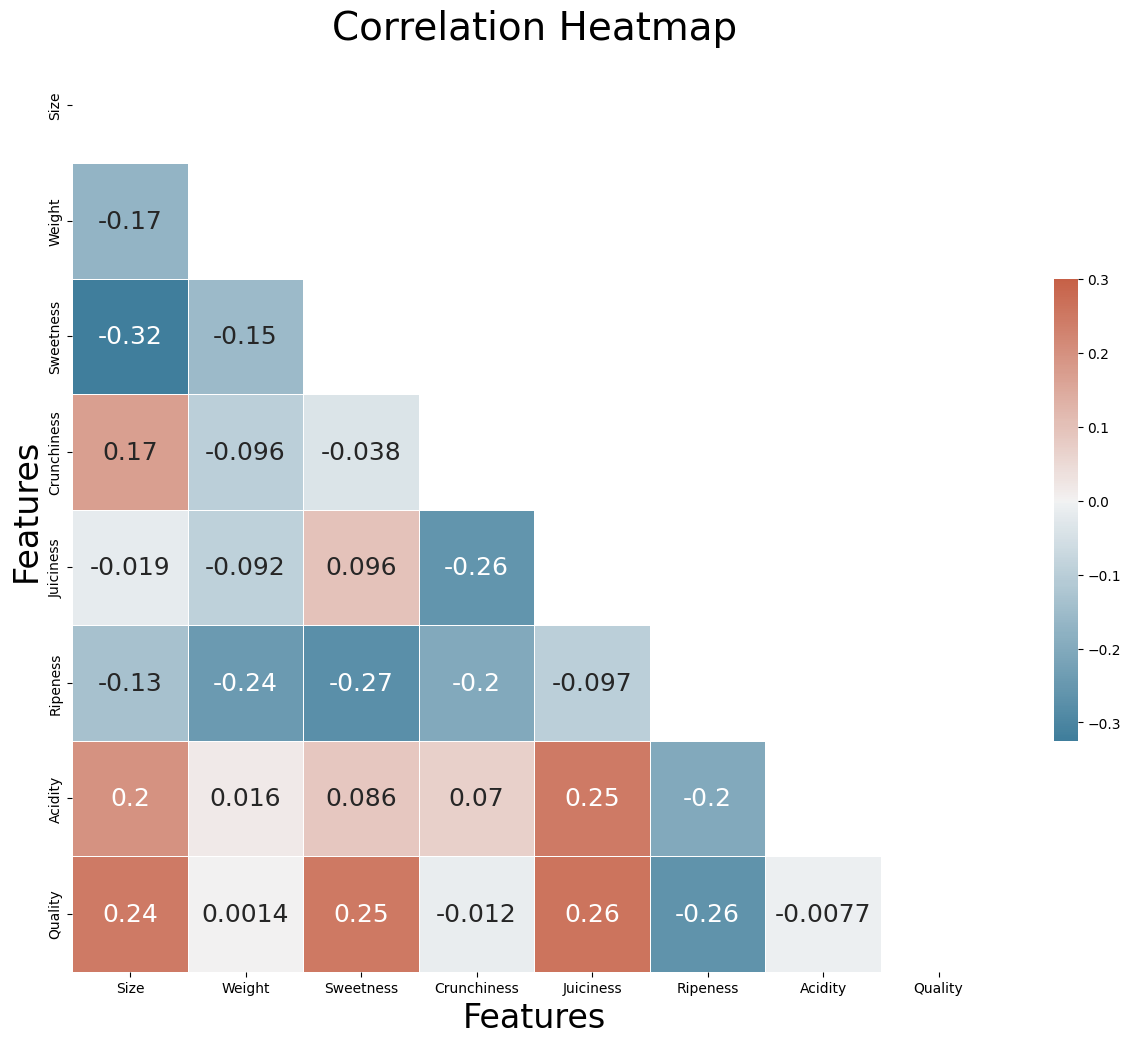

In [16]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(15, 12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"size": 18},
            xticklabels=corr.columns, yticklabels=corr.columns)

plt.title('Correlation Heatmap', fontsize=28)
plt.xlabel('Features', fontsize=24)
plt.ylabel('Features', fontsize=24)
plt.show()

### Distribuzione delle caratteristiche

Questo blocco di codice genera istogrammi con curve di densità per ciascuna variabile numerica nel dataset:

- Si itera su tutte le colonne eccetto "Quality".
- Per ciascuna colonna viene creato un sottografico usando `sns.histplot()`, con:
  - La distribuzione della variabile sull'asse X.
  - La curva di densità impostando `kde=True`.

Questa visualizzazione aiuta a comprendere la distribuzione delle variabili e a individuare eventuali asimmetrie o anomalie nei dati.


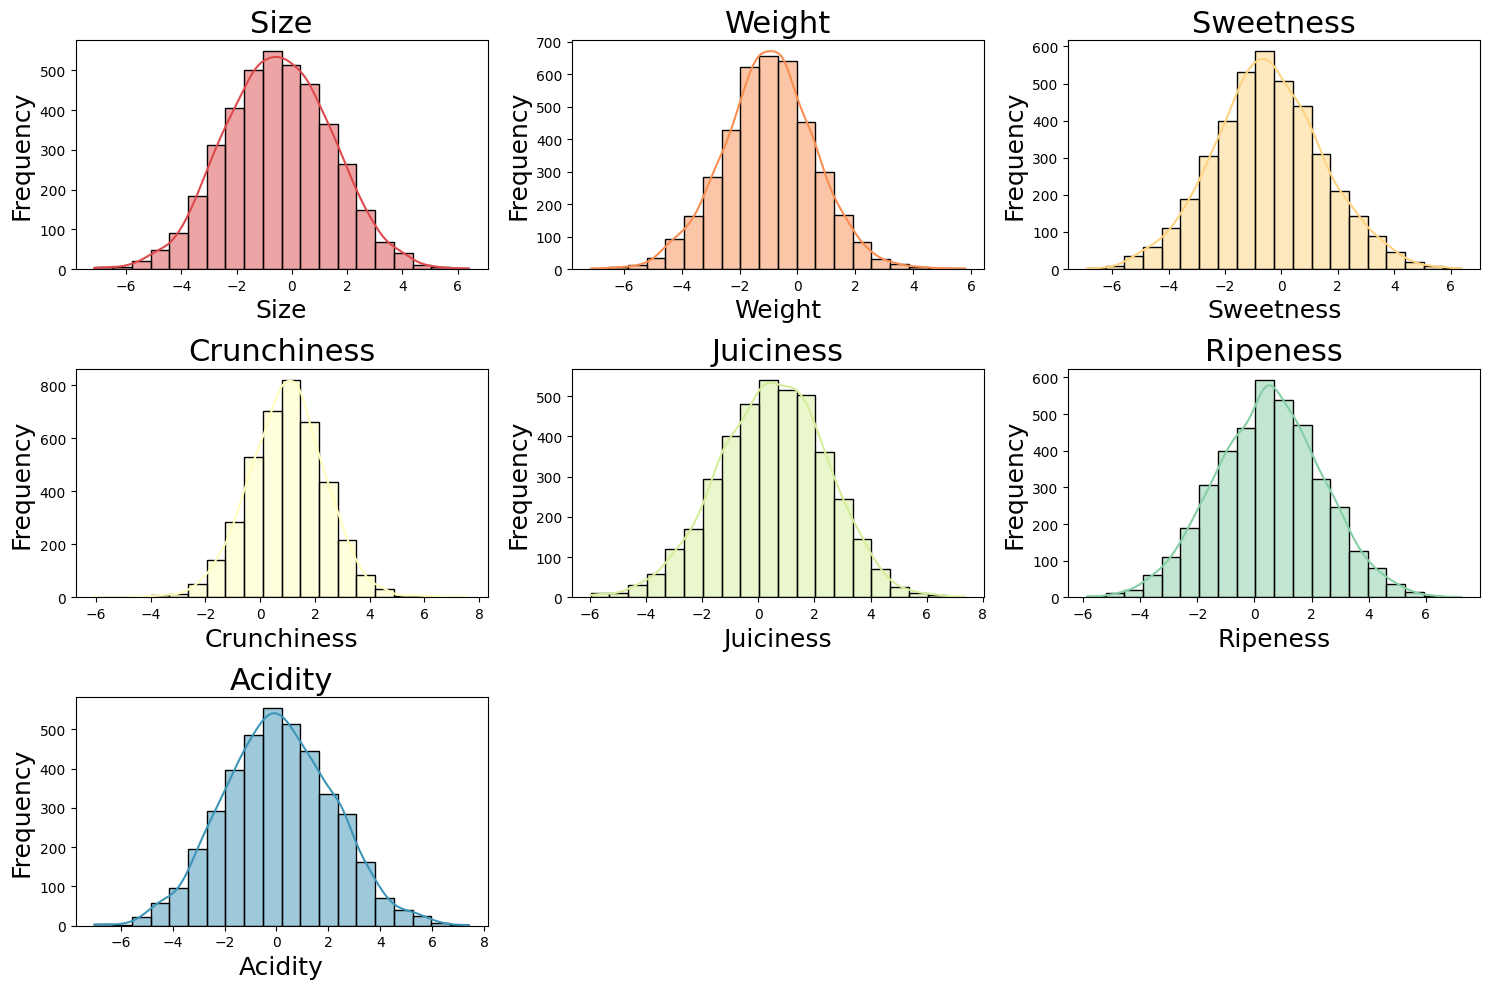

In [17]:
plt.figure(figsize=(15, 10))
sns.set_palette("Spectral")
colors = sns.color_palette("Spectral", n_colors=len(df.columns) - 1)

for i, column in enumerate(df.loc[:, df.columns != 'Quality'], 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=column, kde=True, bins=20, color=colors[i-1])
    plt.title(column, fontsize=22)
    plt.xlabel(column, fontsize=18)
    plt.ylabel('Frequency', fontsize=18)

plt.tight_layout()
plt.show()

### Boxplot delle caratteristiche  

Questo blocco di codice genera boxplot per ciascuna variabile numerica nel dataset, esclusa la colonna "Quality":  

- Si itera su tutte le colonne eccetto "Quality".  
- Per ciascuna colonna viene generato un boxplot verticale con `sns.boxplot()`.   

I boxplot aiutano a individuare outlier, distribuzioni asimmetriche e la variabilità delle caratteristiche del dataset.  


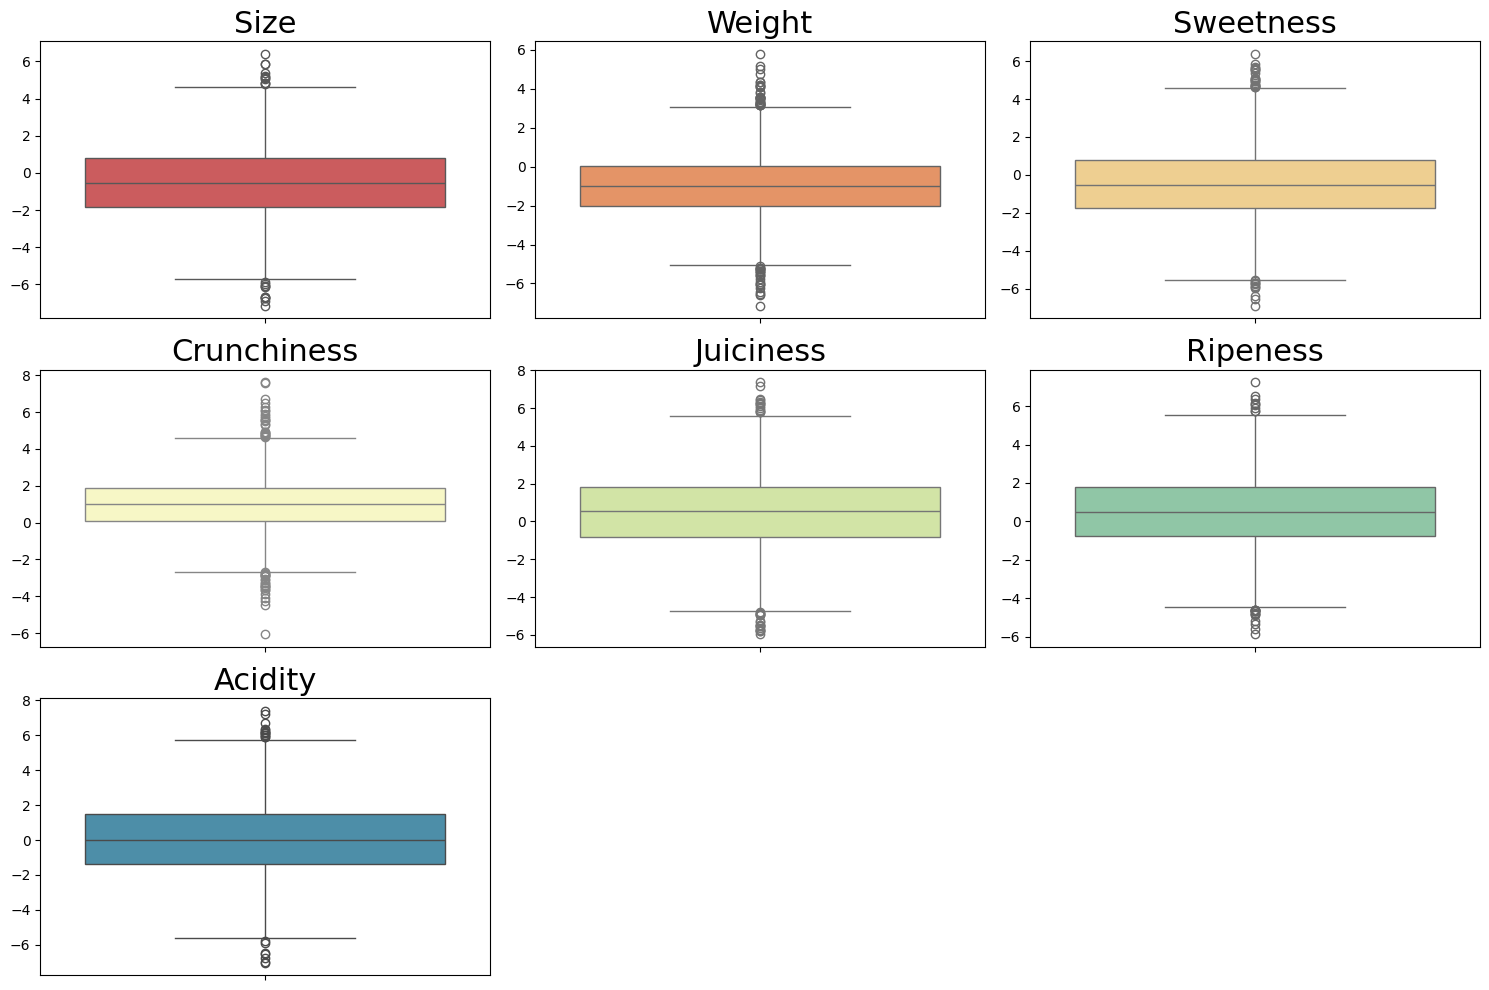

In [18]:
plt.figure(figsize=(15, 10))
sns.set_palette("Spectral")
for i, column in enumerate(df.loc[:, df.columns != 'Quality'], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[column], color=colors[i-1])
    plt.title(column, fontsize=22)
    plt.xlabel('', fontsize=18)
    plt.ylabel('')

plt.tight_layout()
plt.show()

### Normalizzazione dei dati con RobustScaler  

1. **Creazione dello scaler**: `RobustScaler` standardizza le variabili sottraendo la mediana e scalando secondo l'intervallo interquartile (IQR), rendendolo robusto agli outlier.  

2. **Applicazione dello scaler**:  Tutte le colonne eccetto "Quality" vengono trasformate con il metodo `fit_transform()`.  

3. **Visualizzazione**: `df.describe().T` viene utilizzato per visualizzare le statistiche riassuntive delle variabili trasformate.  

Questa procedura garantisce che i dati siano scalati in modo robusto, migliorando le prestazioni degli algoritmi di machine learning.  


In [19]:
robust_scaler = RobustScaler(copy=True)
df.loc[:, df.columns != 'Quality'] = robust_scaler.fit_transform(df.loc[:, df.columns != 'Quality'])
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Size,4000.0,0.004076,0.735257,-2.531374,-0.496917,0.000000e+00,0.503083,2.638940
Weight,4000.0,-0.002355,0.784486,-3.018049,-0.502771,0.000000e+00,0.497229,3.316833
Sweetness,4000.0,0.013494,0.765029,-2.515297,-0.485629,1.172884e-08,0.514371,2.708163
Crunchiness,4000.0,-0.006973,0.765919,-3.851173,-0.510784,1.626904e-08,0.489216,3.615458
Juiciness,4000.0,-0.008380,0.731929,-2.463204,-0.506398,-1.132139e-08,0.493602,2.589877
Ripeness,4000.0,-0.002036,0.738577,-2.509190,-0.502434,0.000000e+00,0.497566,2.653541
Acidity,4000.0,0.018792,0.730724,-2.435370,-0.484790,0.000000e+00,0.515210,2.556212
Quality,4000.0,0.501000,0.500062,0.000000,0.000000,1.000000e+00,1.000000,1.000000


### Standardizzazione dei dati con StandardScaler  

1. **Creazione dello scaler**: `StandardScaler` standardizza i dati rimuovendo la media e scalando secondo la deviazione standard.  

2. **Applicazione dello scaler**: Tutte le colonne eccetto "Quality" vengono trasformate con `fit_transform()`, normalizzando i dati in modo che abbiano media 0 e deviazione standard 1.  

3. **Visualizzazione**: `df.describe().T` viene utilizzato per visualizzare le statistiche riassuntive delle variabili trasformate, inclusi media, deviazione standard, minimi e massimi.  

Questa standardizzazione è utile per molti algoritmi di machine learning che richiedono variabili con la stessa scala per funzionare correttamente.  


In [ ]:
standard_scaler = StandardScaler(copy=True)
df.loc[:, df.columns != 'Quality'] = standard_scaler.fit_transform(df.loc[:, df.columns != 'Quality'])
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Size,4000.0,1.335144e-08,1.000125,-3.448816,-0.681470,-0.005544,0.678768,3.584043
Weight,4000.0,1.907349e-09,1.000125,-3.844645,-0.637970,0.003002,0.636909,4.231561
Sweetness,4000.0,-8.821488e-09,1.000124,-3.305895,-0.652505,-0.017641,0.654797,3.522747
Crunchiness,4000.0,8.583068e-09,1.000125,-5.019697,-0.657868,0.009106,0.647917,4.730115
Juiciness,4000.0,3.814697e-09,1.000125,-3.354335,-0.680504,0.011451,0.685921,3.550325
Ripeness,4000.0,1.430511e-09,1.000126,-3.394996,-0.677601,0.002757,0.676523,3.595980
Acidity,4000.0,-9.536744e-10,1.000125,-3.358955,-0.689240,-0.025720,0.679437,3.472910
Quality,4000.0,5.010000e-01,0.500062,0.000000,0.000000,1.000000,1.000000,1.000000


### Separazione delle variabili indipendenti e dipendenti  

1. Creazione di un DataFrame `X` contenente tutte le colonne del dataset eccetto "Quality". Queste sono le variabili indipendenti utilizzate come input per il modello di machine learning.  

2. Creazione di un DataFrame `y` contenente solo la colonna "Quality", che rappresenta l'etichetta target da prevedere.   

In [ ]:
X = df.drop(["Quality"], axis=1)
y = df["Quality"]

### Random Seed

L'uso di un seme casuale consente di ottenere risultati consistenti durante l'addestramento e la valutazione del modello.  

In [ ]:
RANDOM_STATE = random.randint(0, 1337)

### Suddivisione del dataset in train e test  

La funzione `train_test_split()` divide il dataset negli insiemi di testing e di addestramento.  Il 20% dei dati viene riservato per il test, mentre l'80% viene utilizzato per l'addestramento.  

Questa suddivisione è essenziale per valutare le prestazioni del modello su dati non visti, evitando l'overfitting.  


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

### Creazione dei classificatori

Viene creato un dizionario `classifiers` contenente i tre modelli di machine learning scelti per la classificazione:  
- Support Vector Machine
- Naive Bayes
- Multi Layer Perceptron

In [ ]:
classifiers = {
    "svm": SVC(
        kernel="rbf",
        C=100,
        gamma=0.1,
        probability=True,
        random_state=RANDOM_STATE,
    ),
    "nb": GaussianNB(),
    "mlp": MLPClassifier(
        hidden_layer_sizes=(
            10,
            10,
            10,
        ),
        max_iter=1000,
        random_state=RANDOM_STATE,
    ),
}

### Definizione della griglia di parametri per la GridSearch  

In questo blocco di codice, per ogni classificatore, viene definita una serie di valori di iperparametri sui quali la **grid search** esplorerà diverse combinazioni per trovare la configurazione ottimale per ciascun modello.

In [ ]:
param_grid = {
    "svm": {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto", 0.1, 1],
    },
    "nb": {},
    "mlp": {
        "hidden_layer_sizes": [
            (8, 8, 8),
            (10, 10, 10),
            (12,12,12)
        ],
        "max_iter": [500, 750, 1000]
    },
}

### Esecuzione della GridSearch per ottimizzazione dei parametri

In questo blocco di codice viene eseguita una **grid search** per ciascun modello, al fine di trovare la combinazione di iperparametri ottimale.

1. Per ogni modello viene utilizzata una **cross validation a 5 fold** per la valutazione delle performance.

2. `n_jobs=-1` indica al processo di utilizzare tutti i core disponibili per velocizzare.

3. `grid_search.best_params_` memorizza i parametri ottimali per ciascun modello nella variabile `grid_results`.

4. `grid_search.best_estimator_` seleziona il miglior modello (con i parametri ottimali) e lo sostituisce nel dizionario `classifiers`.

La variabile `grid_results` conterrà i migliori parametri trovati per ciascun modello che verranno utilizzati per l'addestramento finale.


In [ ]:
# grid_results = {}
# for model_key, model in classifiers.items():
#     grid_search = GridSearchCV(model, param_grid[model_key], cv=5, n_jobs=-1)
#     grid_search.fit(X_train, y_train)
#     grid_results[model_key] = grid_search.best_params_
#     classifiers[model_key] = grid_search.best_estimator_ # we use best estimator as model
# grid_results

### Valutazione dei modelli tramite Cross-Validation

In questo blocco di codice viene eseguita una **cross validation a 5 fold** per valutare le prestazioni di ciascun modello sui dati di addestramento.

Il DataFrame `cv_results` contiene i punteggi medi della cross-validation per ciascun modello, permettendo di confrontare le prestazioni tra i diversi classificatori.


In [ ]:
cv_results = {}
for model_name, model in classifiers.items():
    cv_score = cross_val_score(model, X_train, y_train, cv=5)
    cv_results[model_name] = cv_score.mean()
cv_results = pd.DataFrame(cv_results.items())

In [ ]:
cv_results

,0,1
0,svm,0.907500
1,nb,0.751563
2,mlp,0.929063


### Valutazione dei modelli sui dati di test

In questo blocco di codice vengono valutati i modelli sui dati di test per ottenere diverse metriche di performance:

1. **Addestramento e predizione**: Per ogni modello nel dizionario `classifiers`, viene eseguito l'addestramento (`classifier.fit(X_train, y_train)`) utilizzando i dati di addestramento. Successivamente, viene effettuata una previsione sui dati di test con `classifier.predict(X_test)`.

2. **Calcolo delle metriche di performance**:
   - **Accuracy**: La precisione del modello è calcolata con `accuracy_score(y_test, y_pred)`.
   - **Classification Report**: Viene generato un report dettagliato delle metriche di valutazione (precision, recall, F1-score) con `classification_report(y_test, y_pred, output_dict=True)`.
   - **Confusion Matrix**: La matrice di confusione è calcolata con `confusion_matrix(y_test, y_pred)` per analizzare la distribuzione delle predizioni corrette e errate.
   - **ROC Curve**: La curva ROC (Receiver Operating Characteristic) è calcolata con `roc_curve(y_test, y_pred)` per valutare la capacità del modello di distinguere tra le classi.
   - **AUC (Area Under the Curve)**: Il punteggio AUC, che misura l'area sotto la curva ROC, è calcolato con `auc(fpr, tpr)`.

In [ ]:
results = {}
reports = {}
for model_key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(
        y_test, y_pred
    )
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    reports[model_key] = (classification_report(y_test, y_pred))
    results[model_key] = {"accuracy": accuracy, "report": report, "confusion_matrix": cm, "roc_auc": roc_auc, "fpr": fpr, "tpr": tpr}

In [ ]:
for model_name, report in reports.items():
    print(f"Model: {model_name}")
    print(report)

Model: svm
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       404
           1       0.93      0.89      0.91       396

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800

Model: nb
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       404
           1       0.75      0.74      0.75       396

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800

Model: mlp
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       404
           1       0.94      0.93      0.93       396

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.9

In [ ]:
print(results)

{'svm': {'accuracy': 0.91, 'report': {'0': {'precision': 0.8952380952380953, 'recall': 0.9306930693069307, 'f1-score': 0.912621359223301, 'support': 404.0}, '1': {'precision': 0.9263157894736842, 'recall': 0.8888888888888888, 'f1-score': 0.9072164948453608, 'support': 396.0}, 'accuracy': 0.91, 'macro avg': {'precision': 0.9107769423558898, 'recall': 0.9097909790979097, 'f1-score': 0.9099189270343309, 'support': 800.0}, 'weighted avg': {'precision': 0.9106215538847118, 'recall': 0.91, 'f1-score': 0.9099459513562206, 'support': 800.0}}, 'confusion_matrix': array([[376,  28],
       [ 44, 352]]), 'roc_auc': 0.9097909790979097, 'fpr': array([0.        , 0.06930693, 1.        ]), 'tpr': array([0.        , 0.88888889, 1.        ])}, 'nb': {'accuracy': 0.75125, 'report': {'0': {'precision': 0.7506112469437652, 'recall': 0.7599009900990099, 'f1-score': 0.7552275522755227, 'support': 404.0}, '1': {'precision': 0.7519181585677749, 'recall': 0.7424242424242424, 'f1-score': 0.747141041931385, 'sup

### Visualizzazione delle curve ROC per i modelli

In questo blocco di codice viene tracciata la **curva ROC** per ciascun modello, al fine di confrontare la capacità di classificazione di ciascun classificatore:

**Plot delle curve ROC**: Per ogni modello nel dizionario `results`, viene tracciata la curva ROC utilizzando `plt.plot(result[1]["fpr"], result[1]["tpr"])`, dove `fpr` e `tpr` sono i tassi di false positive e true positive ottenuti precedentemente.

Il grafico finale mostra le curve ROC per tutti i modelli (più una fittizia), consentendo di confrontare la loro capacità di discriminare tra le classi, con un valore AUC che quantifica la qualità del modello.


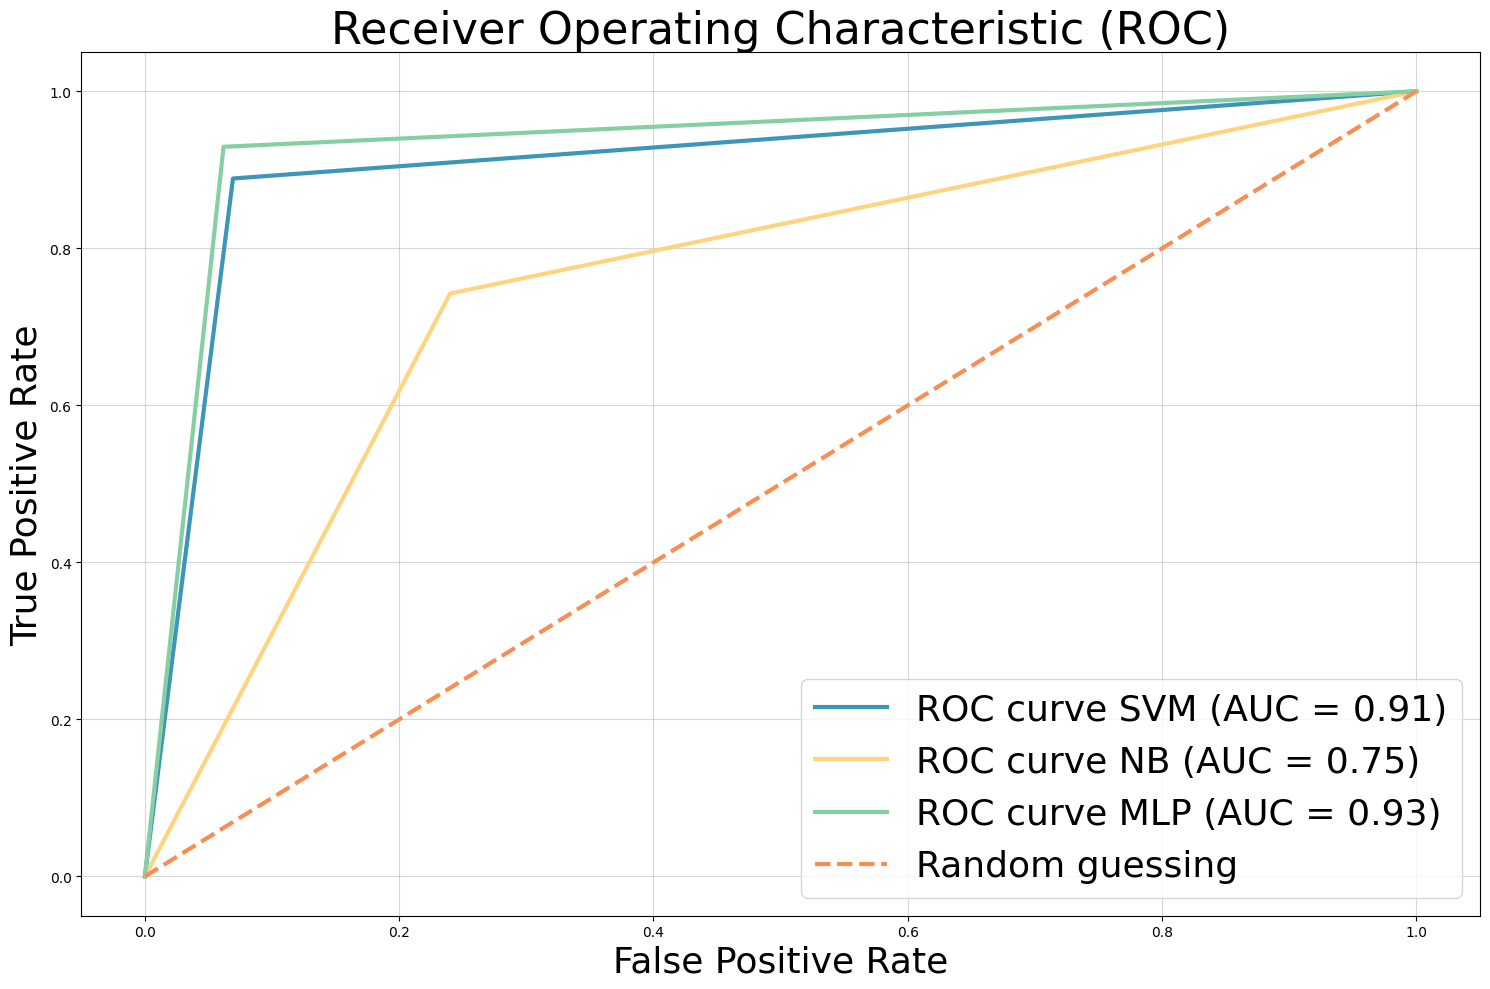

In [ ]:
plt.figure(figsize=(15, 10))
sns.set_palette("Spectral")
for i, result in enumerate(results.items()):
    plt.plot(result[1]["fpr"], result[1]["tpr"], color=colors[(6+3*i)%7], label=f'ROC curve {result[0].upper()} (AUC = {result[1]["roc_auc"]:.2f})', linewidth=3)

plt.plot([0, 1], [0, 1], color=colors[1], linestyle='--', label='Random guessing', linewidth=3)
plt.xlabel('False Positive Rate', fontsize=26)
plt.ylabel('True Positive Rate', fontsize=26)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=32)
plt.legend(loc='lower right', fontsize=26)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

### Visualizzazione delle matrici di confusione

In questo blocco di codice viene tracciata una **matrice di confusione** per ciascun modello, al fine di visualizzare la distribuzione delle predizioni corrette ed errate per ciascuna classe.

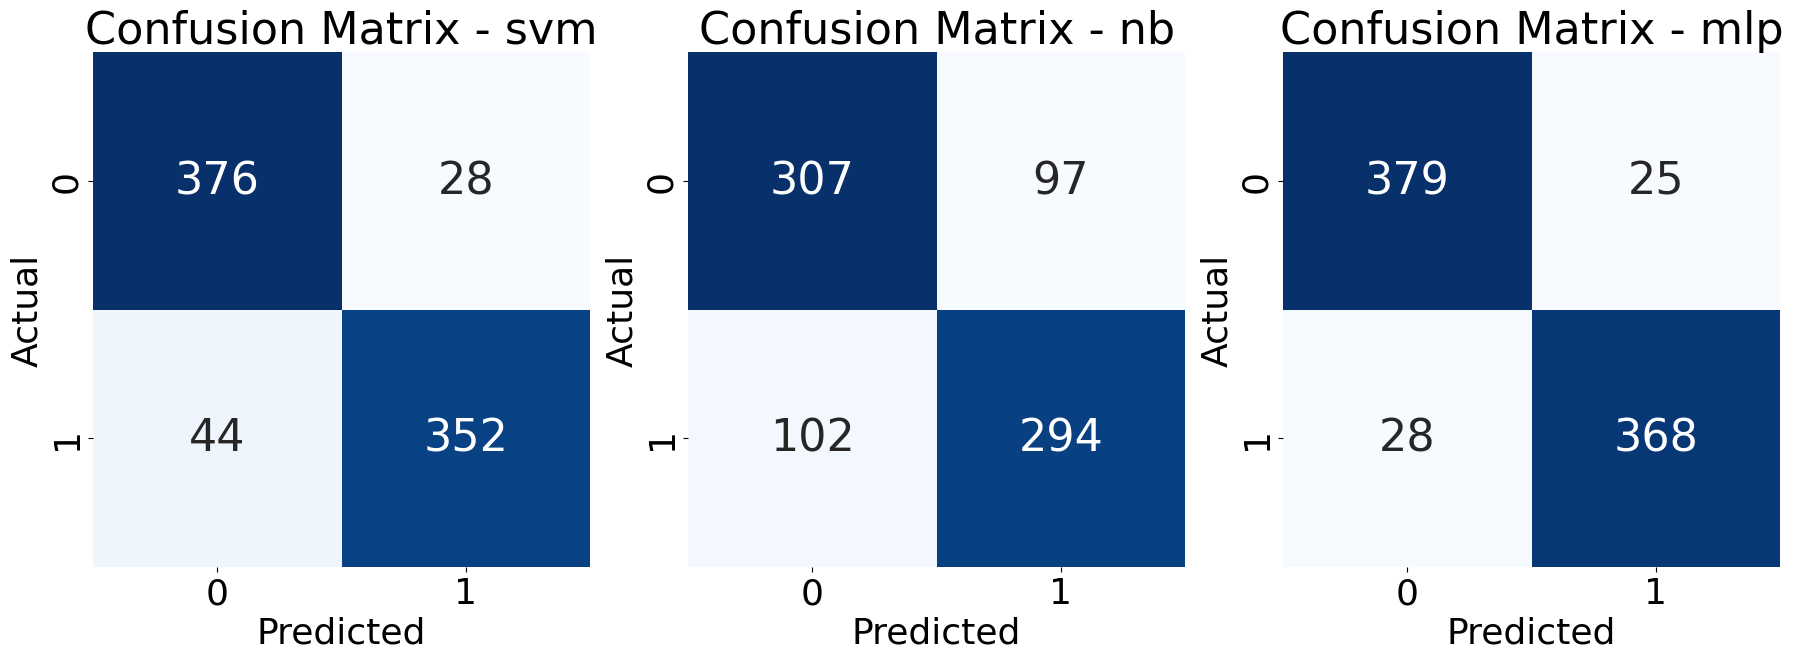

In [ ]:
plt.figure(figsize=(18, 12))
for i, (model_key, result) in enumerate(results.items()):
    cm = result['confusion_matrix']
    plt.subplot(2, 3, i + 1)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False,
        annot_kws={"size": 32},
    )
    plt.title(f"Confusion Matrix - {model_key}", fontsize=32)
    plt.xlabel('Predicted', fontsize=26)
    plt.ylabel('Actual', fontsize=26)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)
plt.tight_layout()
plt.show()


### Confronto tra Precision, Recall e F1-Score

In questo blocco di codice viene mostrato un confronto chiaro delle prestazioni di ciascun modello rispetto alle metriche di precision, recall e F1-score, fornendo una panoramica completa delle performance di classificazione.


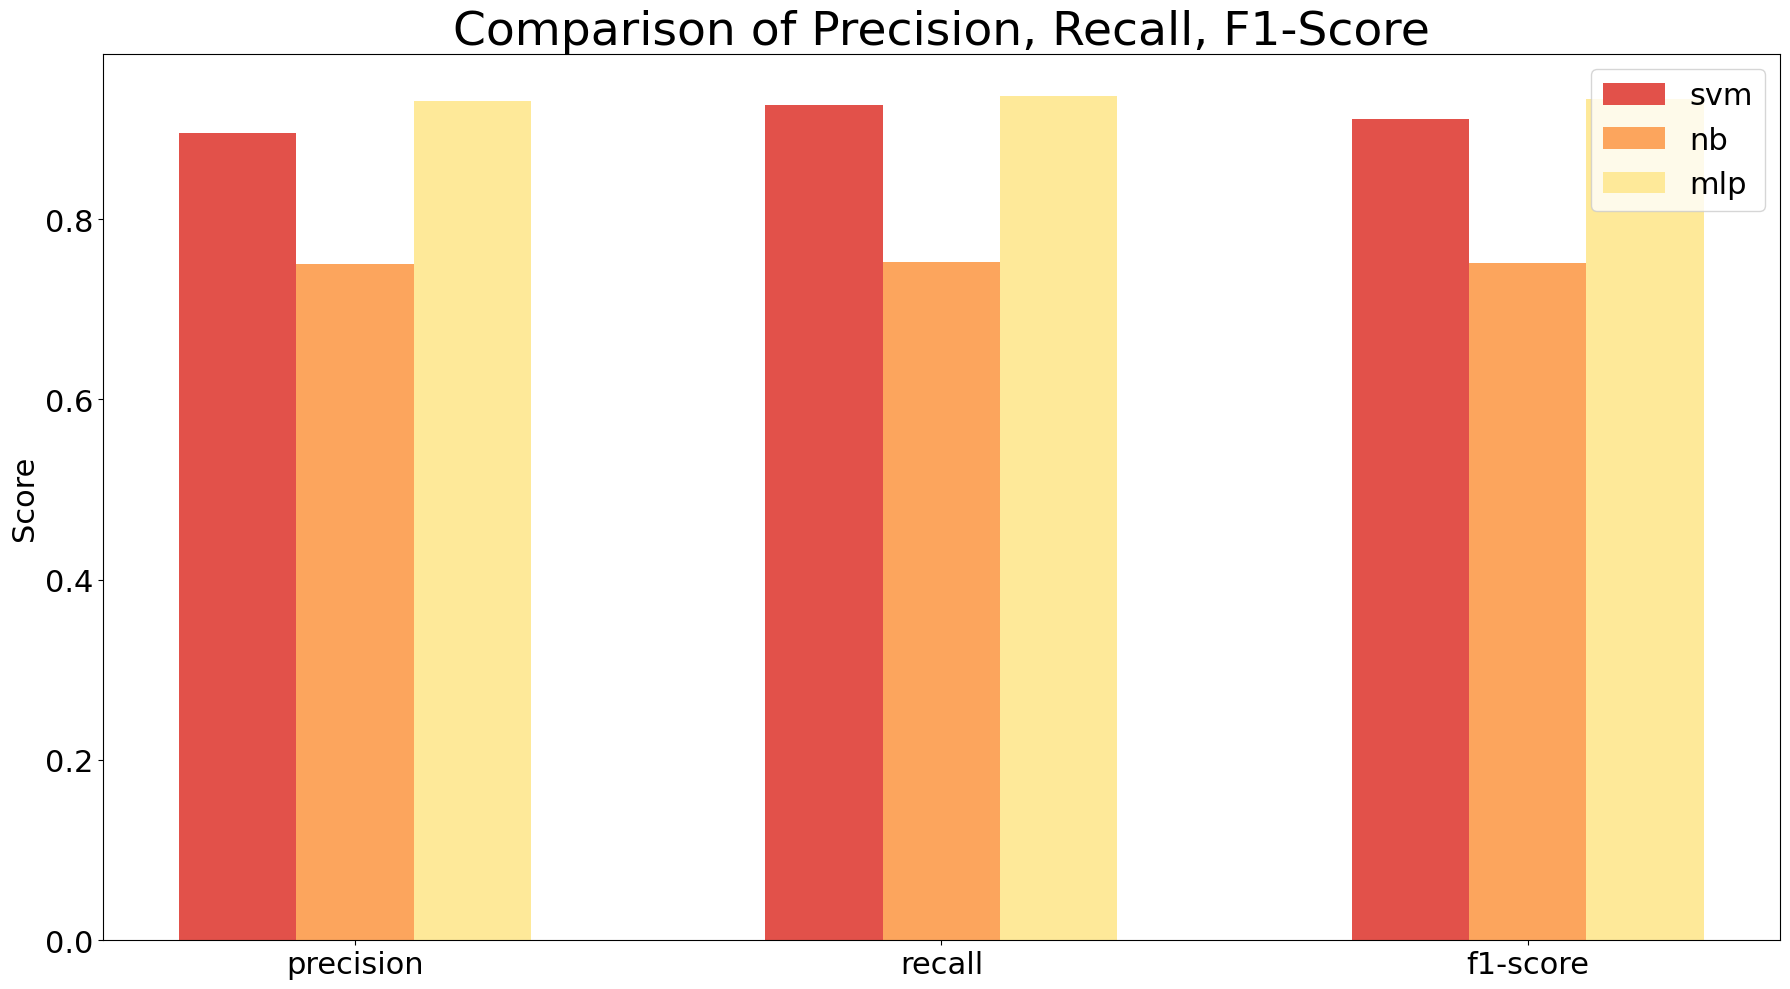

In [ ]:
metrics = ['precision', 'recall', 'f1-score']
plt.figure(figsize=(18, 10))
x = np.arange(len(metrics))

for i, (model_key, result) in enumerate(results.items()):
    scores = [np.mean(result['report'][label][metric]) for metric in metrics for label in result['report'] if label != 'accuracy']
    plt.bar(x + i * 0.2, scores[:len(metrics)], width=0.2, label=model_key)

plt.xticks(x + 0.2, metrics, fontsize=22)
plt.ylabel('Score', fontsize=22)
plt.title('Comparison of Precision, Recall, F1-Score', fontsize=34)
plt.legend(fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.tight_layout()
plt.show()
